In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import nltk 
nltk.download('stopwords')
import spacy
import plotly.express as px
import re
import text_hammer as th
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import requests

from nltk.corpus import stopwords
from collections import Counter

# import text cleaning package(s)
import neattext.functions as nfx


'''
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
'''


import os
from wordcloud import WordCloud
from PIL import Image


[nltk_data] Error loading stopwords: <urlopen error [WinError 10061]
[nltk_data]     No connection could be made because the target machine
[nltk_data]     actively refused it>


In [2]:
# Importing train and test dataset
df=pd.read_csv(r"covid19_tweets.csv")


In [3]:
df.shape

(179108, 13)

In [4]:
# View the dataset
df.head()

user_name         user_location  \
0           ᏉᎥ☻լꂅϮ            astroworld   
1    Tom Basile 🇺🇸          New York, NY   
2  Time4fisticuffs      Pewee Valley, KY   
3      ethel mertz  Stuck in the Middle    
4         DIPR-J&K     Jammu and Kashmir   

                                    user_description         user_created  \
0  wednesday addams as a disney princess keepin i...  2017-05-26 05:46:42   
1  Husband, Father, Columnist & Commentator. Auth...  2009-04-16 20:06:23   
2  #Christian #Catholic #Conservative #Reagan #Re...  2009-02-28 18:57:41   
3  #Browns #Indians #ClevelandProud #[]_[] #Cavs ...  2019-03-07 01:45:06   
4  🖊️Official Twitter handle of Department of Inf...  2017-02-12 06:45:15   

   user_followers  user_friends  user_favourites  user_verified  \
0             624           950            18775          False   
1            2253          1677               24           True   
2            9275          9525             7254          False   
3             197           987             1488          False   
4          101009           168              101          False   

                  date                                               text  \
0  2020-07-25 12:27:21  If I smelled the scent of hand sanitizers toda...   
1  2020-07-25 12:27:17  Hey @Yankees @YankeesPR and @MLB - wouldn't it...   
2  2020-07-25 12:27:14  @diane3443 @wdunlap @realDonaldTrump Trump nev...   
3  2020-07-25 12:27:10  @brookbanktv The one gift #COVID19 has give me...   
4  2020-07-25 12:27:08  25 July : Media Bulletin on Novel #CoronaVirus...   

                            hashtags               source  is_retweet  
0                                NaN   Twitter for iPhone       False  
1                                NaN  Twitter for Android       False  
2                        ['COVID19']  Twitter for Android       False  
3                        ['COVID19']   Twitter for iPhone       False  
4  ['CoronaVirusUpdates', 'COVID19']  Twitter for Android       False

In [5]:
df.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet'],
      dtype='object')

In [6]:
df['source'].unique()

array(['Twitter for iPhone', 'Twitter for Android', 'Twitter Web App',
       'Buffer', 'TweetDeck', 'Twitter for iPad', 'Africa Newsroom',
       'Blood Donors India', 'TweetCaster for Android',
       'Alexander Higgins', 'IFTTT', 'Hootsuite Inc.', 'Sprout Social',
       'Sprinklr', 'assarofficial', 'IAMBLOG2TWITTER', 'CrowdControlHQ',
       'COVID19-Updates', 'EveryoneSocial', 'Dynamic Signal', 'Instagram',
       'TweetCaster for iOS', 'GlobalPandemic.NET', 'Venrap Radio',
       'HeyOrca', 'Twitter for Advertisers', 'Paper.li',
       'Twitter Media Studio', 'Twitter for Mac', 'dlvr.it',
       'Cheap Bots, Done Quick!', 'Prof. Shanku', 'LaterMedia',
       'SEMrush Social Media Tool', 'Twitterrific for iOS',
       "Sebastian's Twitter Bot", 'Threader_client', 'COVID19FactoidBot',
       'PwC UK SMART', 'tweet pro stiff', 'UK COVID-19 Alerts',
       'Resistbot Open Letters', 'preprint-alert', 'ContentStudio.io',
       'Peeping Moon', 'TweetAutomaticos', 'Orlo', 'AgoraPulse Ma

In [7]:
#sns.countplot(df['text'])

In [8]:
# Distribution of Sources
df['source'].value_counts().nlargest(5)

Twitter Web App        56891
Twitter for Android    40179
Twitter for iPhone     35472
TweetDeck               8543
Hootsuite Inc.          7321
Name: source, dtype: int64

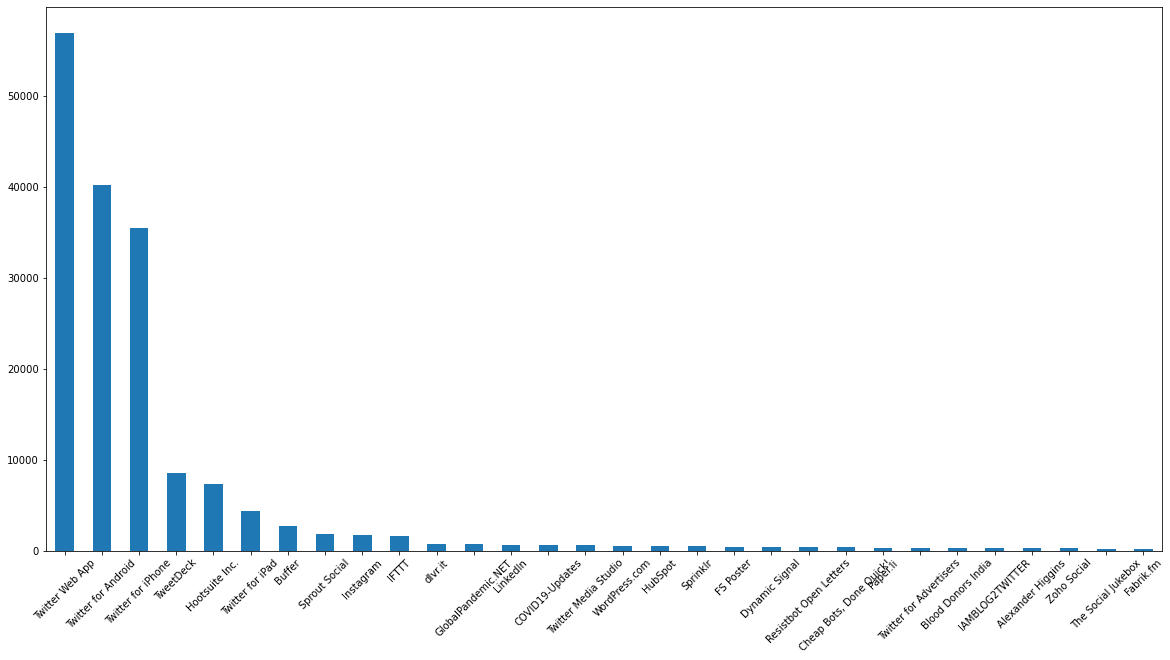

In [9]:
plt.figure(figsize=(20,10))
df['source'].value_counts().nlargest(30).plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:ylabel='source'>

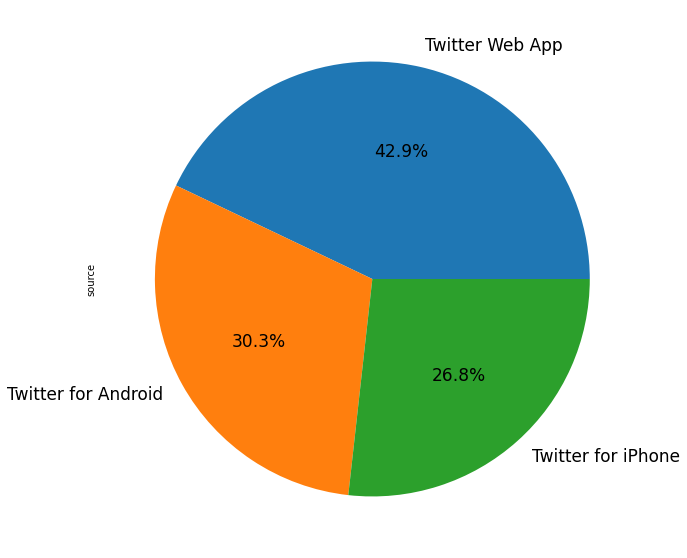

In [10]:
df_filter = df[(df["source"] == "Twitter for Android") | (df["source"] == "Twitter Web App") | (df["source"] == "Twitter for iPhone")]
df_filter["source"].value_counts().plot.pie(figsize=(20, 10), autopct='%1.1f%%', fontsize=17)

<AxesSubplot:ylabel='user_verified'>

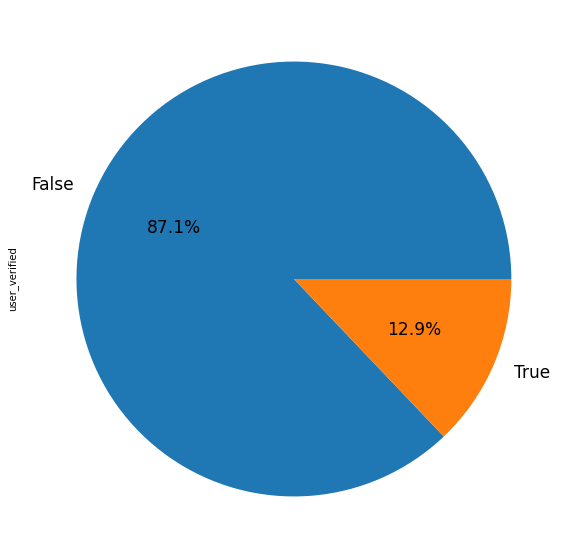

In [11]:
df["user_verified"].value_counts().plot.pie(figsize=(20, 10), autopct='%1.1f%%', fontsize=17)

<AxesSubplot:title={'center':'Top 100 locations tweet'}>

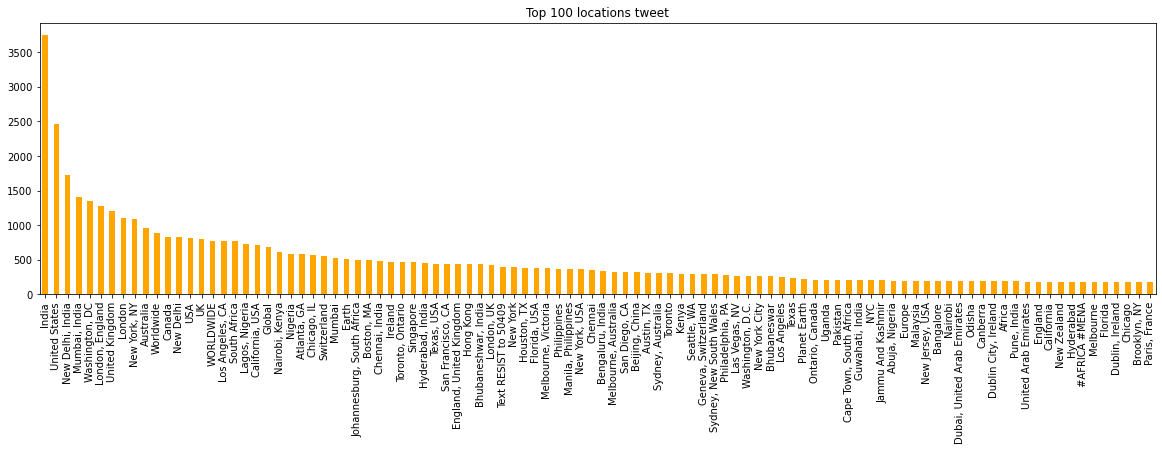

In [12]:
df["user_location"].value_counts().head(100).plot.bar(title="Top 100 locations tweet", figsize=(20, 5), color="orange")

Testing Benford's Law

In [13]:
def count_occur_numbers(dataframe):
    count_total = 0
    number_occur = {}
    for current in dataframe:
        for number in str(current):
            number = int(number)
            if number != 0:
                if number not in number_occur:
                    number_occur[number] = 0
                number_occur[number] += 1
                count_total = count_total + 1
    return number_occur

def number_probability(number_occur, total):
    probability = list()
    indexes = list()
    for index in number_occur:
        indexes.append(index[0])
        probability.append(round(index[1] / total, 4))
    return indexes, probability

In [14]:
def count_occur(dataframe):
    number_occur = count_occur_numbers(dataframe)
    total_sum = sum(number_occur.values())
    number_occur = sorted(number_occur.items(), key=lambda x: x[1], reverse=True)
    
    return number_occur, total_sum

user_followers = df['user_followers']
user_friends = df['user_friends']
user_favourites = df['user_favourites']

In [15]:
user_number_occur, user_total_sum = count_occur(user_followers)
friends_number_occur, friends_total_sum = count_occur(user_friends)
favorite_number_occur, favorite_total_sum = count_occur(user_favourites)

indexes_user, probability_user = number_probability(user_number_occur, user_total_sum)
indexes_friends, probability_friends = number_probability(friends_number_occur, friends_total_sum)
indexes_favorite, probability_favorite = number_probability(favorite_number_occur, favorite_total_sum)

In [16]:
def distribution_plot(X, y, title, color):
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(X, y)

    z = np.polyfit(X, y, 1)
    p = np.poly1d(z)
    
    plt.plot(X, p(X),"r--")
    plt.xticks(np.arange(len(X)))
    plt.title(f"Probability {title}")
    plt.xlabel("Number occur")
    plt.ylabel("Proba")
    plt.bar(X, y, color=color)

number  probability %
0       1          17.53
1       2          13.51
2       3          11.93
3       4          10.77
4       5          10.24
5       6           9.77
6       7           9.25
7       8           8.71
8       9           8.30

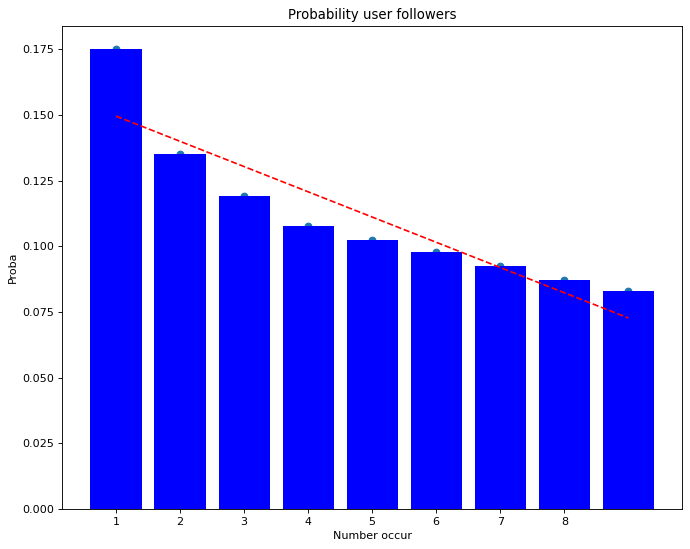

In [17]:
distribution_plot(X=indexes_user, y=probability_user, title='user followers', color='blue')
pd.DataFrame({'number': np.array(indexes_user), 'probability %': np.array(probability_user) * 100}).head(10)

number  probability %
0       1          18.02
1       2          13.73
2       3          11.58
3       4          11.03
4       5           9.98
5       6           9.18
6       9           9.03
7       7           8.86
8       8           8.59

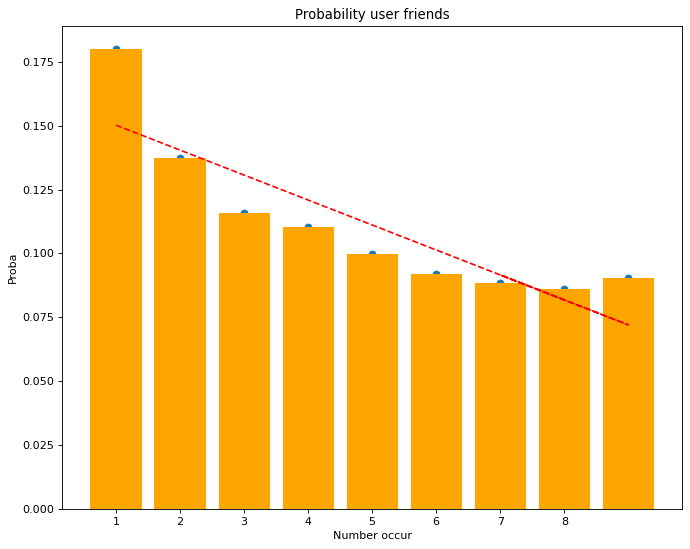

In [18]:
distribution_plot(X=indexes_friends, y=probability_friends, title='user friends', color='orange')
pd.DataFrame({'number': np.array(indexes_friends), 'probability %': np.array(probability_friends) * 100}).head(10)

number  probability %
0       1          17.42
1       2          13.44
2       3          11.47
3       4          10.81
4       5          10.23
5       6           9.58
6       7           9.21
7       8           9.07
8       9           8.76

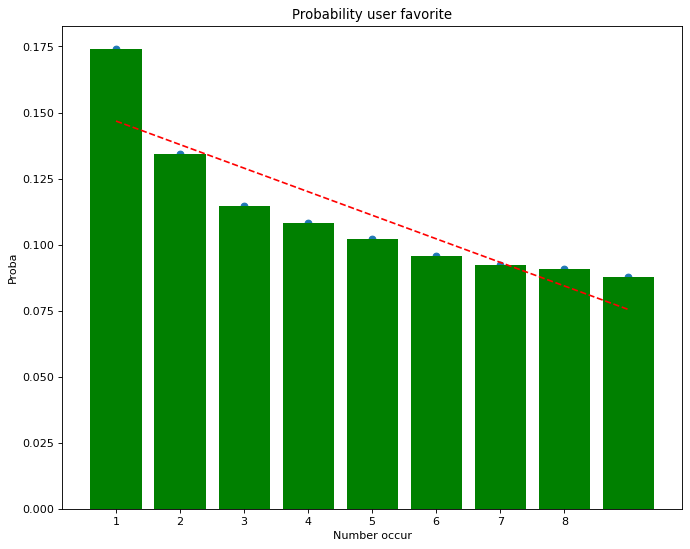

In [19]:
distribution_plot(X=indexes_favorite, y=probability_favorite, title='user favorite', color='green')
pd.DataFrame({'number': np.array(indexes_favorite), 'probability %': np.array(probability_favorite) * 100}).head(10)

In [20]:
India = ' '.join(text for text in df['text'][df['user_location'] == 'India'])
China = ' '.join(text for text in df['text'][df['user_location'] == 'China'])
USA = ' '.join(text for text in df['text'][df['user_location'] == 'USA'])
SA = ' '.join(text for text in df['text'][df['user_location'] == 'South Africa'])

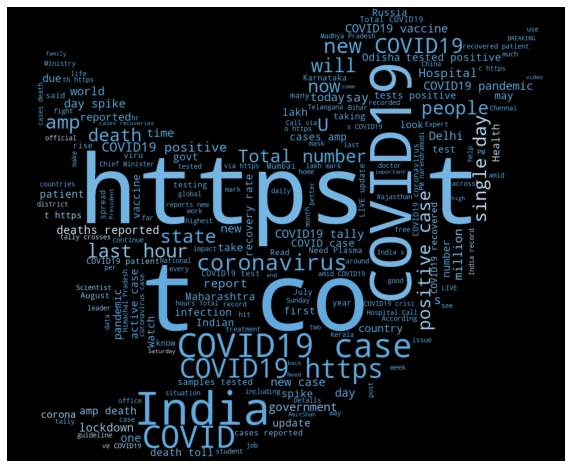

In [70]:
# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream = True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors =ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color = 'black', height = 1500, width = 4000, mask = Mask).generate(India)

# Size of the image generated 
plt.figure(figsize = (10, 20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func = image_colors), interpolation = "hamming")

plt.axis('off')
plt.show()

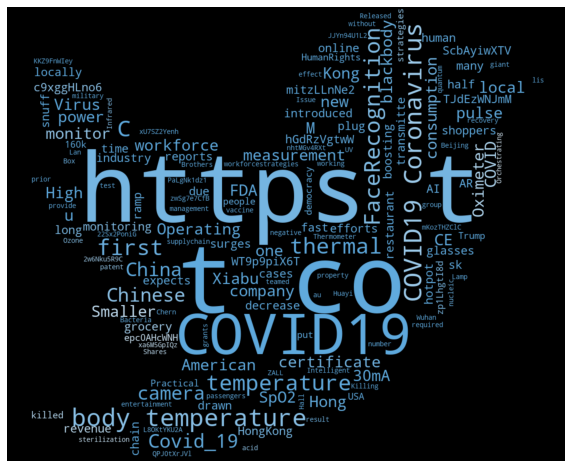

In [67]:
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream = True).raw))
image_colors = ImageColorGenerator(Mask)
wc = WordCloud(background_color = 'black', height = 1500, width = 4000, mask = Mask).generate(China)
plt.figure(figsize = (10, 20))
plt.imshow(wc.recolor(color_func = image_colors), interpolation = "hamming")
plt.axis('off')
plt.show()

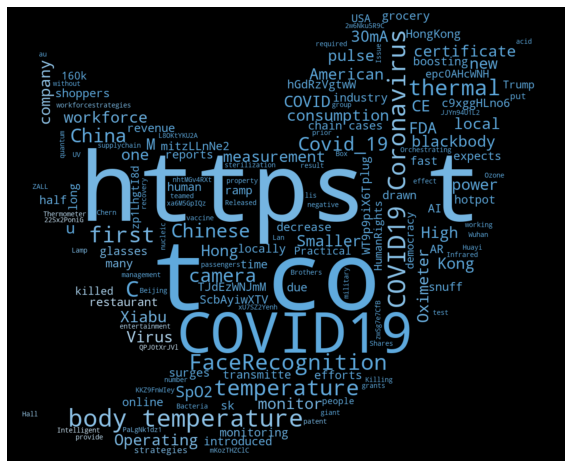

In [68]:
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream = True).raw))
image_colors = ImageColorGenerator(Mask)
wc = WordCloud(background_color = 'black', height = 1500, width = 4000, mask = Mask).generate(China)
plt.figure(figsize = (10, 20))
plt.imshow(wc.recolor(color_func = image_colors), interpolation = "hamming")
plt.axis('off')
plt.show()

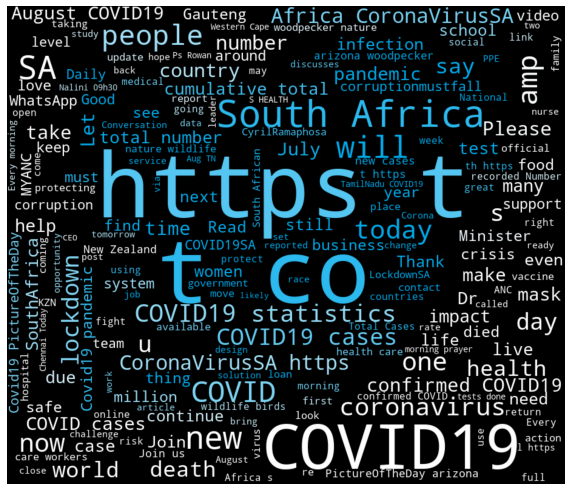

In [69]:
Mask = np.array(Image.open(requests.get('http://clipart-library.com/new_gallery/18-189677_instagram-logo-twitter-logo-bird-twitter-logo-2017.png', stream = True).raw))
image_colors = ImageColorGenerator(Mask)
wc = WordCloud(background_color = 'black', height = 1500, width = 4000, mask = Mask).generate(SA)
plt.figure(figsize = (10, 20))
plt.imshow(wc.recolor(color_func = image_colors), interpolation = "hamming")
plt.axis('off')
plt.show()


In [22]:
nlp = spacy.load("en_core_web_sm")

In [23]:
text=str(df['text'])

In [24]:
doc = nlp(text)

In [25]:
#Parts of Speech - pos
for token in doc:
    print(token.text, token.pos_)

0 NUM
         SPACE
If SCONJ
I PRON
smelled VERB
the DET
scent NOUN
of ADP
hand NOUN
sanitizers NOUN
toda NOUN
... PUNCT

 SPACE
1 NUM
         SPACE
Hey INTJ
@Yankees VERB
@YankeesPR PROPN
and CCONJ
@MLB PROPN
- PUNCT
would AUX
n't PART
it PRON
... PUNCT

 SPACE
2 NUM
         SPACE
@diane3443 X
@wdunlap NOUN
@realDonaldTrump ADP
Trump PROPN
nev PROPN
... PUNCT

 SPACE
3 NUM
         SPACE
@brookbanktv VERB
The DET
one NUM
gift NOUN
# SYM
COVID19 NOUN
has AUX
give VERB
me PRON
... PUNCT

 SPACE
4 NUM
         SPACE
25 NUM
July PROPN
: PUNCT
Media PROPN
Bulletin PROPN
on ADP
Novel PROPN
# X
CoronaVirus PROPN
... PUNCT

                                 SPACE
... PUNCT
                       
 SPACE
179103 NUM
    SPACE
Thanks NOUN
@IamOhmai PROPN
for ADP
nominating VERB
me PRON
for ADP
the DET
@WH PROPN
... PUNCT

 SPACE
179104 NUM
    SPACE
2020 NUM
! PUNCT
The DET
year NOUN
of ADP
insanity NOUN
! PUNCT
Lol PROPN
! PUNCT
# SYM
COVID19 ADJ
http X
... PUNCT

 SPACE
179105 NUM
    SPACE


In [26]:
spacy.displacy.render(doc,style='ent',jupyter=True)

In [27]:
for ent in doc.ents:
    if ent.label_ == 'PERSON':
        print(ent.text,ent.label_)

Lol PERSON
Juan Lucena PERSON
Length PERSON


Change the type of column

In [28]:
df.user_name = df.user_name.astype('category') 
df.user_name = df.user_name.cat.codes.astype(str)
df.date= pd.to_datetime (df.date).dt.date 
df.head()

user_name         user_location  \
0     89755            astroworld   
1     76403          New York, NY   
2     76147      Pewee Valley, KY   
3     84572  Stuck in the Middle    
4     18398     Jammu and Kashmir   

                                    user_description         user_created  \
0  wednesday addams as a disney princess keepin i...  2017-05-26 05:46:42   
1  Husband, Father, Columnist & Commentator. Auth...  2009-04-16 20:06:23   
2  #Christian #Catholic #Conservative #Reagan #Re...  2009-02-28 18:57:41   
3  #Browns #Indians #ClevelandProud #[]_[] #Cavs ...  2019-03-07 01:45:06   
4  🖊️Official Twitter handle of Department of Inf...  2017-02-12 06:45:15   

   user_followers  user_friends  user_favourites  user_verified        date  \
0             624           950            18775          False  2020-07-25   
1            2253          1677               24           True  2020-07-25   
2            9275          9525             7254          False  2020-07-25   
3             197           987             1488          False  2020-07-25   
4          101009           168              101          False  2020-07-25   

                                                text  \
0  If I smelled the scent of hand sanitizers toda...   
1  Hey @Yankees @YankeesPR and @MLB - wouldn't it...   
2  @diane3443 @wdunlap @realDonaldTrump Trump nev...   
3  @brookbanktv The one gift #COVID19 has give me...   
4  25 July : Media Bulletin on Novel #CoronaVirus...   

                            hashtags               source  is_retweet  
0                                NaN   Twitter for iPhone       False  
1                                NaN  Twitter for Android       False  
2                        ['COVID19']  Twitter for Android       False  
3                        ['COVID19']   Twitter for iPhone       False  
4  ['CoronaVirusUpdates', 'COVID19']  Twitter for Android       False

In [29]:
remove_url= lambda x: re.sub(r"https\S+", "", str(x))
text_en_lr = df['text'].apply(remove_url)
text_en_lr.head()

0    If I smelled the scent of hand sanitizers toda...
1    Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2    @diane3443 @wdunlap @realDonaldTrump Trump nev...
3    @brookbanktv The one gift #COVID19 has give me...
4    25 July : Media Bulletin on Novel #CoronaVirus...
Name: text, dtype: object

In [30]:
text_en_lr_lc = text_en_lr.apply(lambda x: x.lower()) 
text_en_lr_lc.head()

0    if i smelled the scent of hand sanitizers toda...
1    hey @yankees @yankeespr and @mlb - wouldn't it...
2    @diane3443 @wdunlap @realdonaldtrump trump nev...
3    @brookbanktv the one gift #covid19 has give me...
4    25 july : media bulletin on novel #coronavirus...
Name: text, dtype: object

In [31]:
import string

In [32]:
text_en_lr_lc_pr = text_en_lr_lc.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation))) 
text_en_lr_lc_pr.head()

0    if i smelled the scent of hand sanitizers toda...
1    hey yankees yankeespr and mlb  wouldnt it have...
2    diane3443 wdunlap realdonaldtrump trump never ...
3    brookbanktv the one gift covid19 has give me i...
4    25 july  media bulletin on novel coronavirusup...
Name: text, dtype: object

In [33]:
word_list= [word for line in text_en_lr_lc_pr for word in line.split()]
word_list[:5]

['if', 'i', 'smelled', 'the', 'scent']

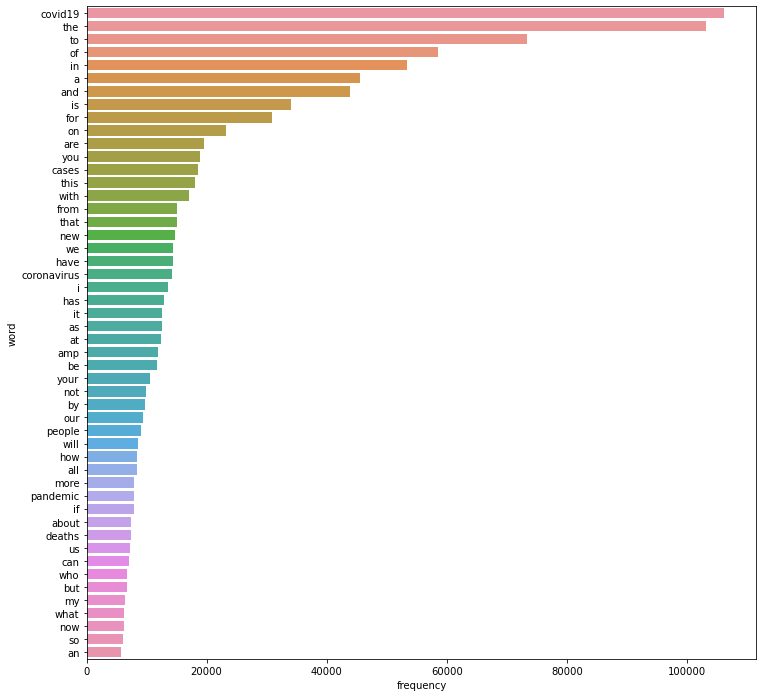

In [34]:
counts = Counter(word_list).most_common(50)
counts_df = pd.DataFrame(counts)
counts_df
counts_df.columns = ['word', 'frequency']

fig, ax = plt.subplots(figsize= (12, 12))

ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df) 
plt.savefig('wordcount_bar.png')

In [35]:
counts_df

word  frequency
0       covid19     106202
1           the     103201
2            to      73410
3            of      58498
4            in      53388
5             a      45551
6           and      43810
7            is      34096
8           for      30876
9            on      23192
10          are      19602
11          you      18903
12        cases      18596
13         this      18009
14         with      17060
15         from      15083
16         that      15045
17          new      14683
18           we      14469
19         have      14403
20  coronavirus      14176
21            i      13621
22          has      12871
23           it      12493
24           as      12485
25           at      12338
26          amp      11907
27           be      11661
28         your      10635
29          not       9868
30           by       9767
31          our       9363
32       people       9053
33         will       8512
34          how       8455
35          all       8385
36         more       7972
37     pandemic       7869
38           if       7837
39        about       7466
40       deaths       7429
41           us       7245
42          can       7039
43          who       6741
44          but       6701
45           my       6452
46         what       6179
47          now       6166
48           so       6029
49           an       5750

In [36]:
fig = px.treemap(counts_df, path=['word'], values='frequency',title='Tree Of Most Common Words')
fig.show()

In [37]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.figure_factory as ff
from collections import Counter

In [38]:
com = np.array(Image.open("D:\covid 19\yoga-gd9aad4396_1280.png"))

In [39]:
list= df['text'].tolist()
filtered_list = ("").join(list) #convert the list into a string of positive
filtered_list = filtered_list.lower()

In [40]:
wordcloud1 = WordCloud( max_words=200, min_font_size=20, margin=0, mask = com, 
                      background_color = "white").generate(filtered_list)

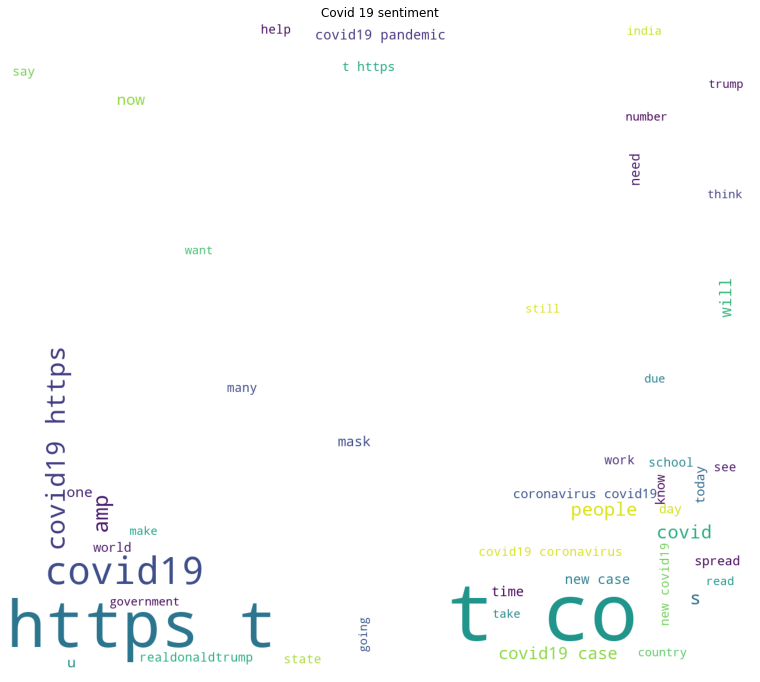

In [41]:
plt.figure(figsize=[15,12])
plt.imshow(wordcloud1)
plt.axis("off")
plt.title("Covid 19 sentiment")
plt.show()

In [42]:

def wordcloud(df, feature):
    wordcloud = WordCloud(width = 1000,
                         height = 800,
                         colormap = 'Set3',
                         margin = 0,
                         max_words = 200,
                         min_word_length = 4,
                         max_font_size = 130, min_font_size = 15,
                         background_color ='gray').generate(str(df['text']))
    plt.figure(figsize = (20,15))
    plt.imshow(wordcloud)
    plt.title("Covid-19 twitter sentiment")
    plt.axis('off')

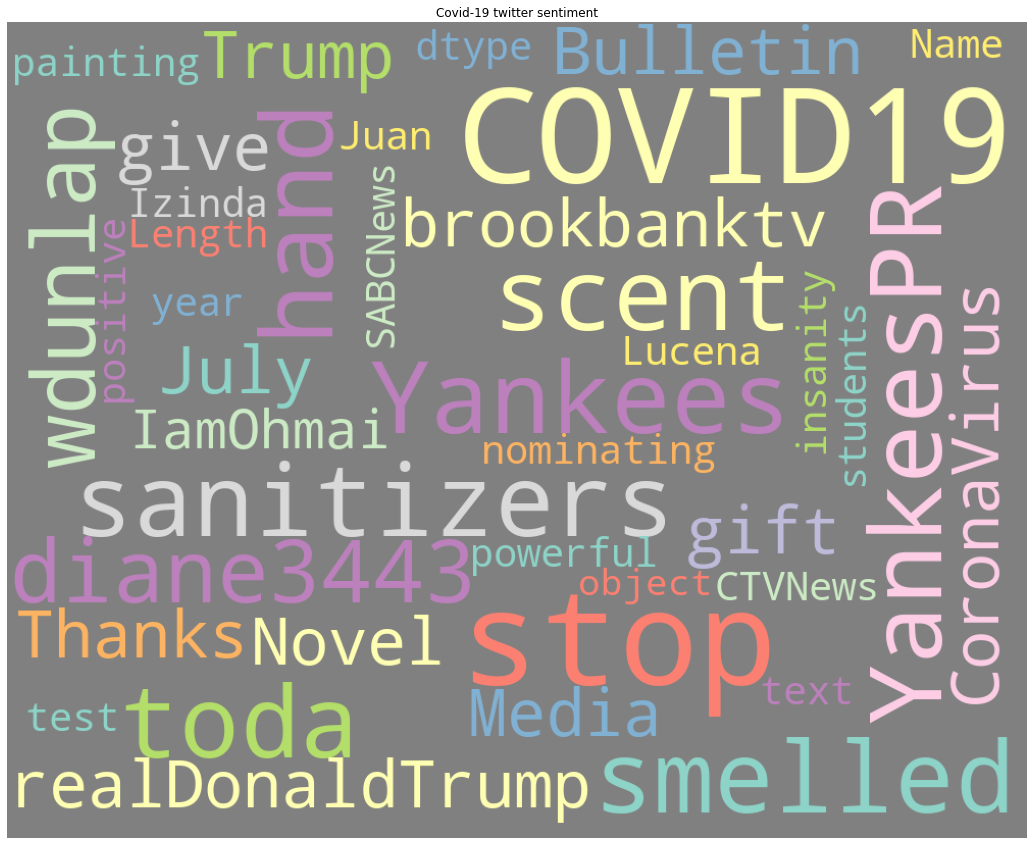

In [43]:
wordcloud(df,'user_name')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '29674'),
  Text(1, 0, '17372'),
  Text(2, 0, '84004'),
  Text(3, 0, '56559'),
  Text(4, 0, '10817'),
  Text(5, 0, '32328'),
  Text(6, 0, '33102'),
  Text(7, 0, '57648'),
  Text(8, 0, '33108'),
  Text(9, 0, '2169')])

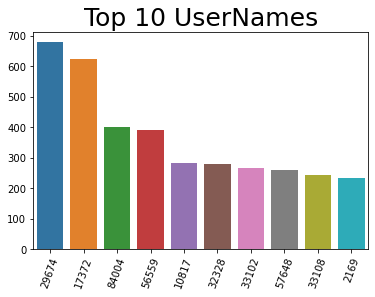

In [44]:
import seaborn as sns
user_count = df['user_name'].value_counts()
user_count = user_count[:10]
sns.barplot(x = user_count.index, y = user_count.values, data =df)
plt.title('Top 10 UserNames', fontsize = 25)
plt.xticks(rotation = 70)

In [45]:
from textblob import TextBlob

In [46]:
# Create a function to get to get the subjectivity and Polarity
def getSentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity
    
    if sentiment_polarity > 0:
        sentiment_label = 'Positive'
    elif sentiment_polarity < 0:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    result = {'polarity' : sentiment_polarity,
              'subjectivity' : sentiment_subjectivity,
              'sentiment': sentiment_label}
    return result

In [47]:
getSentiment(df['text'].iloc[0])

{'polarity': -0.25, 'subjectivity': 0.25, 'sentiment': 'Negative'}

In [48]:
df['sentiment_results'] = df['text'].apply(getSentiment)
df['sentiment_results'].head()

0    {'polarity': -0.25, 'subjectivity': 0.25, 'sen...
1    {'polarity': 0.5, 'subjectivity': 0.5, 'sentim...
2    {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...
3    {'polarity': 0.0, 'subjectivity': 0.3571428571...
4    {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...
Name: sentiment_results, dtype: object

In [49]:
df = df.join(pd.json_normalize(df['sentiment_results']))

In [50]:
df.head()

user_name         user_location  \
0     89755            astroworld   
1     76403          New York, NY   
2     76147      Pewee Valley, KY   
3     84572  Stuck in the Middle    
4     18398     Jammu and Kashmir   

                                    user_description         user_created  \
0  wednesday addams as a disney princess keepin i...  2017-05-26 05:46:42   
1  Husband, Father, Columnist & Commentator. Auth...  2009-04-16 20:06:23   
2  #Christian #Catholic #Conservative #Reagan #Re...  2009-02-28 18:57:41   
3  #Browns #Indians #ClevelandProud #[]_[] #Cavs ...  2019-03-07 01:45:06   
4  🖊️Official Twitter handle of Department of Inf...  2017-02-12 06:45:15   

   user_followers  user_friends  user_favourites  user_verified        date  \
0             624           950            18775          False  2020-07-25   
1            2253          1677               24           True  2020-07-25   
2            9275          9525             7254          False  2020-07-25   
3             197           987             1488          False  2020-07-25   
4          101009           168              101          False  2020-07-25   

                                                text  \
0  If I smelled the scent of hand sanitizers toda...   
1  Hey @Yankees @YankeesPR and @MLB - wouldn't it...   
2  @diane3443 @wdunlap @realDonaldTrump Trump nev...   
3  @brookbanktv The one gift #COVID19 has give me...   
4  25 July : Media Bulletin on Novel #CoronaVirus...   

                            hashtags               source  is_retweet  \
0                                NaN   Twitter for iPhone       False   
1                                NaN  Twitter for Android       False   
2                        ['COVID19']  Twitter for Android       False   
3                        ['COVID19']   Twitter for iPhone       False   
4  ['CoronaVirusUpdates', 'COVID19']  Twitter for Android       False   

                                   sentiment_results  polarity  subjectivity  \
0  {'polarity': -0.25, 'subjectivity': 0.25, 'sen...     -0.25      0.250000   
1  {'polarity': 0.5, 'subjectivity': 0.5, 'sentim...      0.50      0.500000   
2  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...      0.00      0.000000   
3  {'polarity': 0.0, 'subjectivity': 0.3571428571...      0.00      0.357143   
4  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...      0.00      0.000000   

  sentiment  
0  Negative  
1  Positive  
2   Neutral  
3   Neutral  
4   Neutral

In [51]:
df['sentiment'].value_counts()

Neutral     74862
Positive    74640
Negative    29606
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

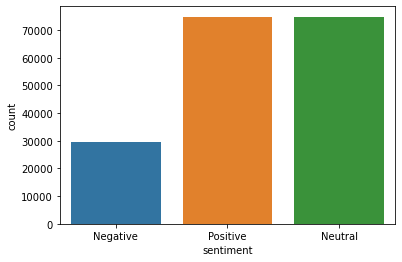

In [52]:
sns.countplot(df['sentiment'])

In [53]:
positive_tweets = df.query('sentiment == "Positive"')['text']
positive_tweets.shape

(74640,)

In [54]:
negative_tweets = df.query('sentiment == "Negative"')['text']
negative_tweets.shape

(29606,)

In [55]:
neutral_tweets = df.query('sentiment == "Neutral"')['text']
neutral_tweets.shape

(74862,)

In [56]:
# Create a function to remove stopwords and convert to tokens
def stop_token(df):
    df_list = df.apply(nfx.remove_stopwords).tolist()
    # Tokenization
    token = [token for line in df_list for token in line.split()]
    return token

In [57]:
positive_tokens = stop_token(positive_tweets)
negative_tokens = stop_token(negative_tweets)
neutral_tokens = stop_token(neutral_tweets)

In [58]:
from collections import Counter

def getTokenCount(docx, num=30):
    word_tokens = Counter(docx)
    most_common = word_tokens.most_common(num)
    result = dict(most_common)
    return result

In [59]:
most_common_positive_words = getTokenCount(positive_tokens)
most_common_negative_words = getTokenCount(negative_tokens)
most_common_neutral_words = getTokenCount(neutral_tokens)

In [60]:
def createDF(common_dict):
    return pd.DataFrame(common_dict.items(), columns=['words','count'])


In [61]:
positive_df = createDF(most_common_positive_words)
negative_df = createDF(most_common_negative_words)
neutral_df = createDF(most_common_neutral_words)

In [62]:
positive_df.head()

words  count
0  #COVID19  28338
1       new   9855
2     cases   8872
3     &amp;   5338
4         -   4357

In [63]:
def plotCommonWords(df, sentiment=None):
    plt.figure(figsize=(20,10))
    sns.barplot(x='words', y='count', data = df)
    plt.title(f'Most common {sentiment} words', fontsize=20)
    plt.xticks(rotation=45)
    return plt.show()

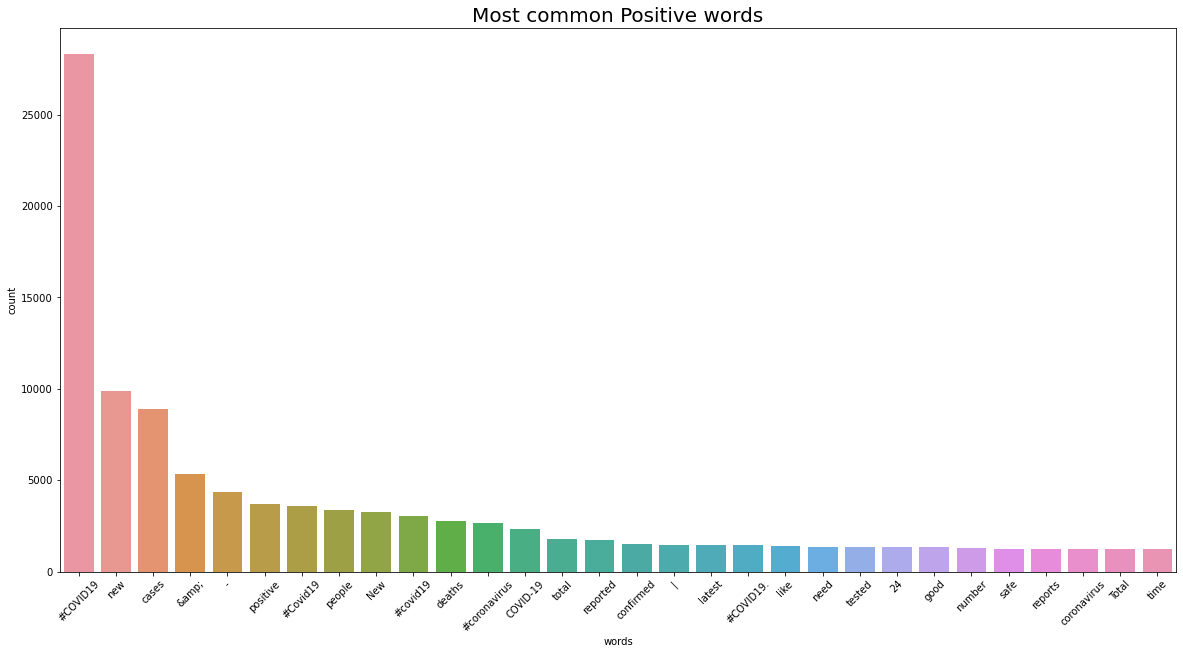

In [64]:
plotCommonWords(positive_df, 'Positive')

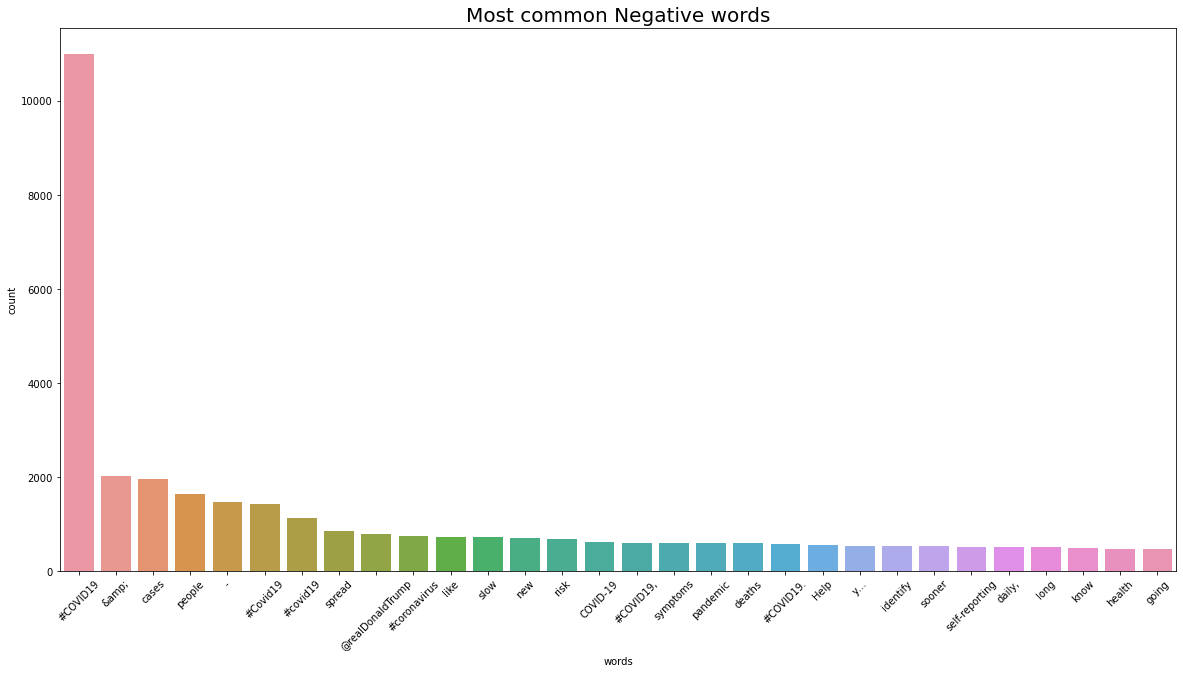

In [65]:
plotCommonWords(negative_df, 'Negative')

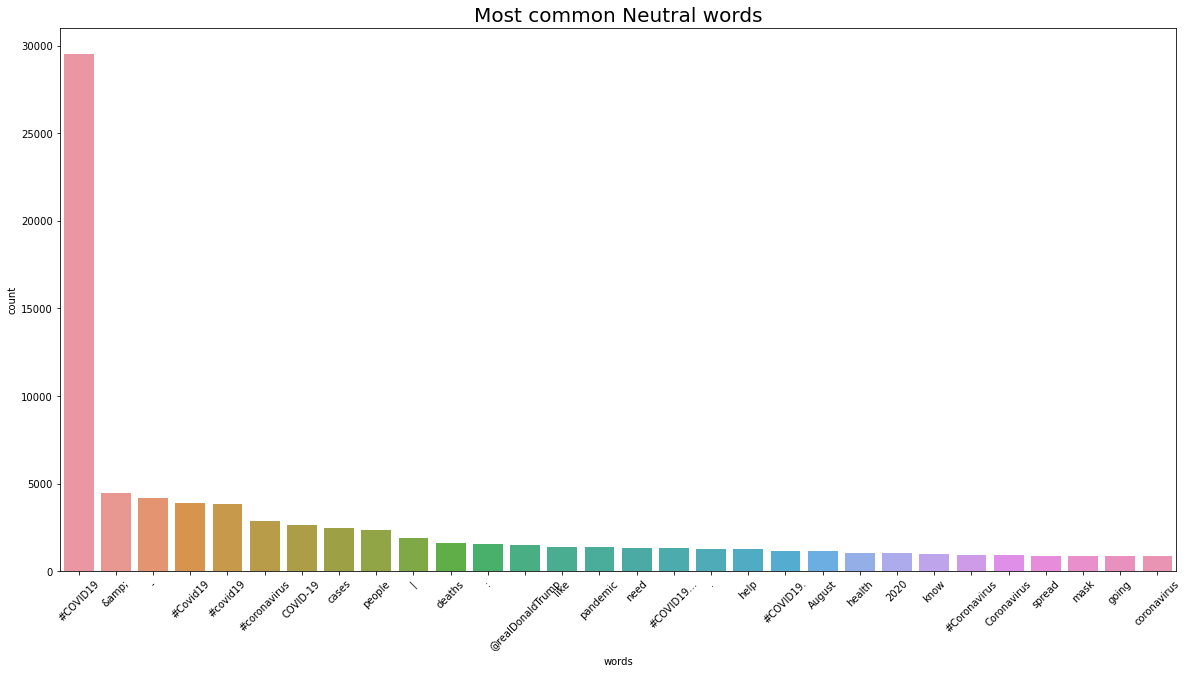

In [66]:
plotCommonWords(neutral_df, 'Neutral')